In [95]:
#####################
#  1-D simulation of mechanochemical model  #
#                Yuan He                    #
#               15/04/2024                  #
#####################  

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from sympy import *
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import interp1d

##----------Initial setting----------##
# Initialize grid
X = 1        # Initial Length of the spatial domain
T = 15       # Total simulation time
Nx = 500    # Number of spatial grid points
Nt = 1000    # Number of time steps
dx = X / Nx  # Spatial step size
dt = T / Nt  # Time step size
x = np.linspace(0, X, Nx + 1) # Spatial grid
t = np.linspace(0, T, Nt + 1) # Temporal grid

# Initialze variables
v = np.zeros(Nx + 1)
E = np.zeros(Nx + 1)
rho = np.ones(Nx + 1)
rho_0 = np.ones(Nx + 1)
rho_new = np.copy(rho)
rho_0_new = np.copy(rho)
E_new = np.copy(rho)
rho_flux = np.zeros(Nx + 1)
v_real = np.zeros(Nx+1)
rho_real = np.zeros(Nx+1)
L_values = np.ones(Nt + 1)

# Parameters
chi = 0.2
alpha = 8
beta = 6
sigma = 5
tau = 0.1
eta = 0.1
g = 4
k = 10

# Stored variables
dLvalues = []
E0_values = [] 
kymo_E = []
kymo_r = []
kymo_p = []
kymo_v = []
kymo_rho=[]

# Initialize Length at t=0
L_values[0] = 20

# Scaled variables
rho = rho*L_values[0]
rho_0 = rho_0*L_values[0]
E = E* L_values[0]

##----------Finish initial setting----------##

0.0
0
20.0


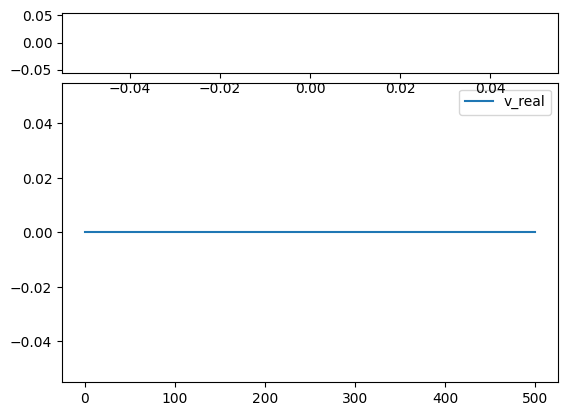

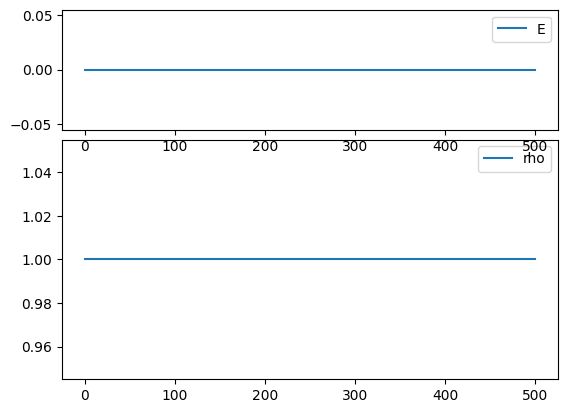

0.5
0.500271446212647
20.226629336870218


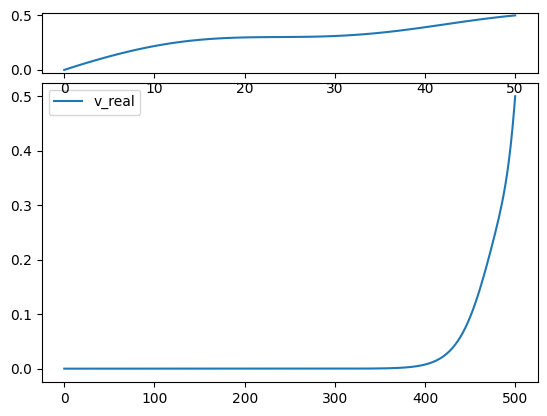

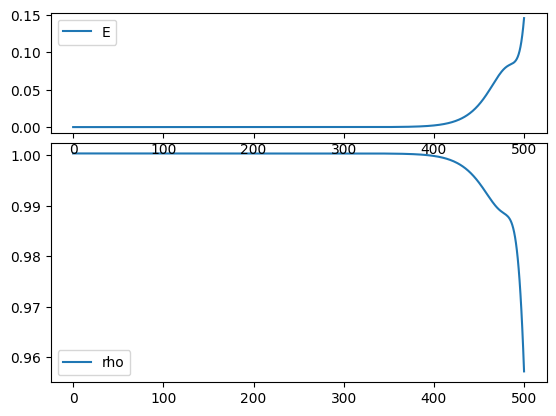

1.0
0.708959417853267
20.663338491963184


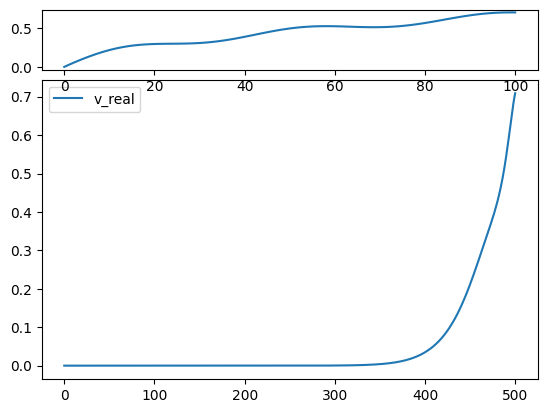

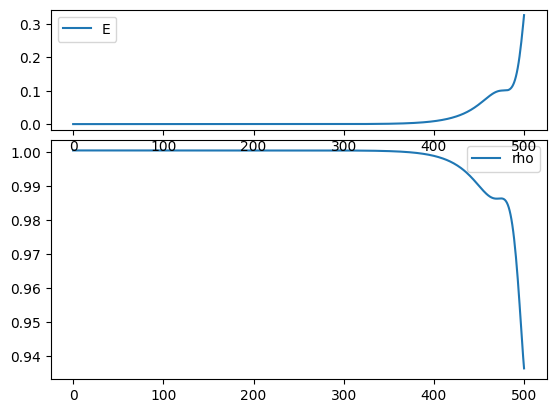

1.5
0.844568012891242
21.23496403730788


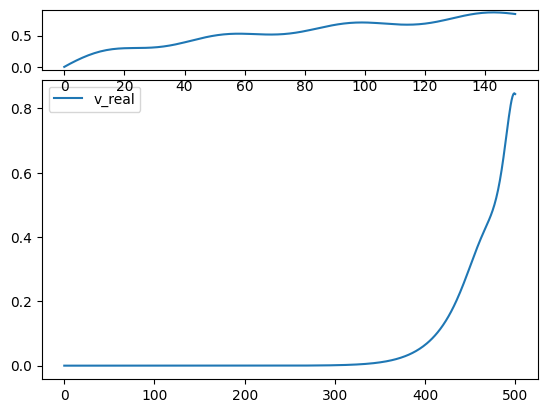

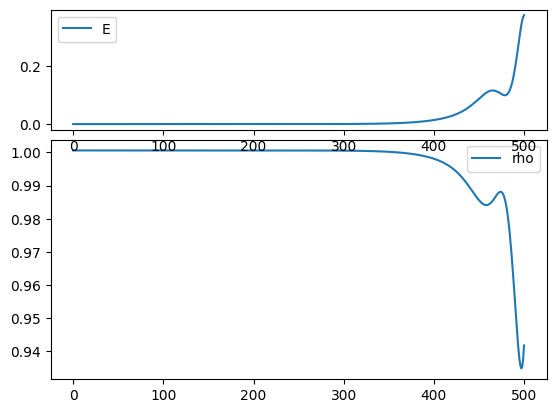

2.0
0.934926109518591
21.911859591810867


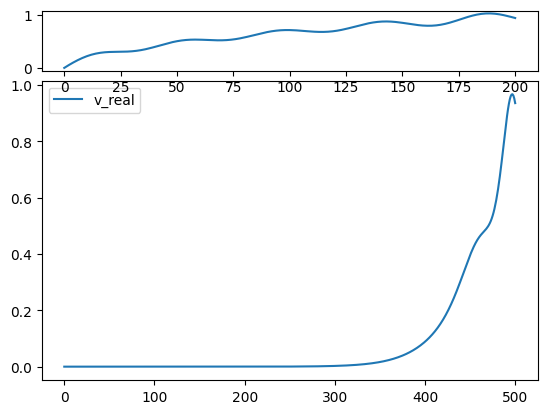

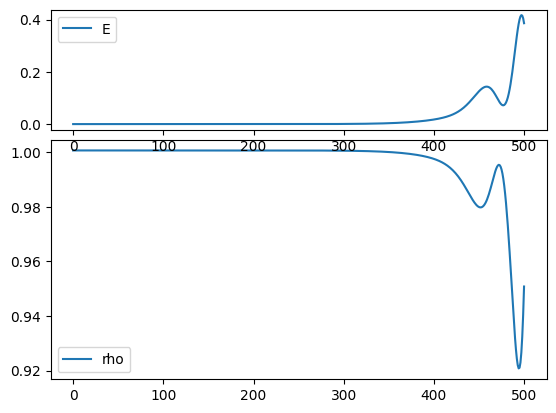

2.5
0.982409233353698
22.669462239502842


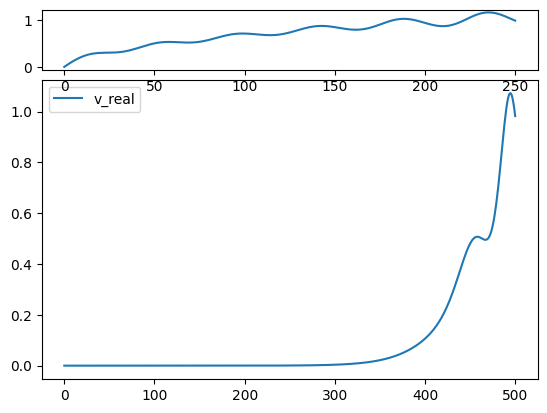

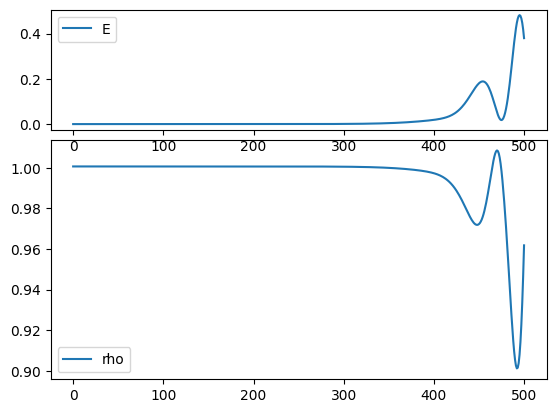

3.0
0.988867218755364
23.4792563318038


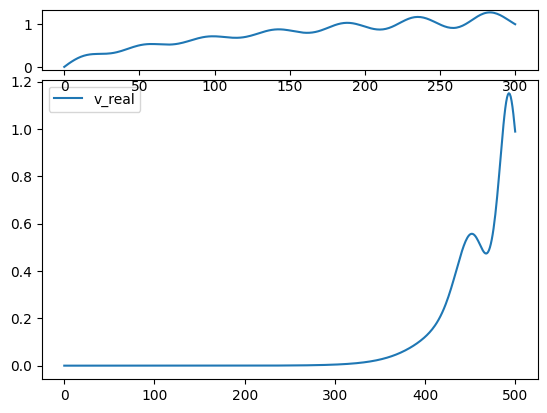

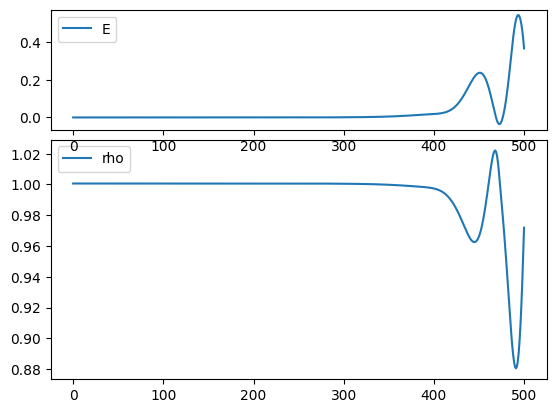

KeyboardInterrupt: 

In [96]:
for n in range(Nt):

    ##----------Calculate E and rho_0 based on ODEs----------##

    for i in range(0, Nx+1):
        # Calculate ODE
        rho_0_new[i] = rho_0[i]+(-rho_0[i]+L_values[n]+alpha*E[i])*dt
        E_new[i] = E[i] + (-E[i]-E[i]**3/L_values[n]**2-beta*(rho[i]-L_values[n]))/tau*dt
    rho_0 = rho_0_new
    E = E_new

    ##----------Finish calculating E and rho_0----------##
    
    ##----------Calculate S using FVM method----------##

    # Initialze grids
    r_original =np.linspace(0,X, Nx+1)

    # Create interpolation function
    rho_interp = interp1d(r_original, rho, kind='linear', fill_value="extrapolate")
    rho_0_interp = interp1d(r_original, rho_0, kind='linear', fill_value="extrapolate")

    # Define equations
    def odes(r, y):
        s, u = y
        rho_val = rho_interp(r)
        rho_0_val = rho_0_interp(r)
        return [u,L_values[n]**2/chi*(s +(rho_val-rho_0_val)/L_values[n])]

    # Define boundary conditions
    def bc(ya, yb):
        return [ya[1],yb[0]-1*sigma*(1 - np.exp(- 1*n/400))]

    # Initialize grid and estimate solution
    r_guess = np.linspace(0,X, Nx+1)
    y_guess = np.zeros((2, r_guess.size))
  
    # Use BVP method
    sol = solve_bvp(odes, bc, r_guess, y_guess)
    s = sol.sol(r_guess)[0]
    
    ##----------Finish calculating S----------##
    
    ##----------Calculate V ----------##

    # Calculate dL and L
    dL = Symbol('dL')
    solution = solve((s[Nx] -s[Nx-1])/(L_values[n]*dx)-dL,dL)
    dL_value = dL.subs({dL: solution[0]})
    dLvalues.append(dL_value)
    L_values[n+1] = L_values[n]+dL_value*dt
    v_real[0] = 0
    
    for i in range(1,Nx):
        v[i] = (s[i] -s[i-1])/(L_values[n]*dx)-i/Nx * dL_value
        v_real[i] = (s[i] -s[i-1])/(L_values[n]*dx)
    
    v_real[Nx] = v[Nx] + Nx / Nx * dL_value 
   
    ##----------Finish calculating V ----------##
    
    ##----------Calculate rho using Fvm----------##
     
    rho_flux[0] = rho[0] * v_real[0]/L_values[n]
    rho_flux[1] = rho[1] * v_real[1]/L_values[n]
    rho_real[0] = rho[0]/L_values[n] - (rho_flux[1] - rho_flux[0]) * dt / ( dx* L_values[n])
        
    # Update rho using upwind finite volume method     
    for i in range(1, Nx):
        
        rho_flux[i] = rho[i] * v_real[i]/L_values[n]
        rho_flux[i+1] = rho[i+1] * v_real[i+1]/L_values[n]
        rho_flux[i-1] = rho[i-1] * v_real[i-1]/L_values[n]
        
        if v_real[i] >=0:
            rho_real[i] = rho[i]/L_values[n] - (rho_flux[i] - rho_flux[i-1]) * dt / ( dx* L_values[n])
        else:
            rho_real[i] = rho[i]/L_values[n] - (rho_flux[i+1] - rho_flux[i]) * dt / ( dx* L_values[n]) 
    
    if v_real[Nx-1] >=0:
        # Nx bd with no flux:   
        rho_flux[Nx] = rho[Nx] * v_real[Nx]/L_values[n]
        rho_real[Nx] = rho[Nx]/L_values[n] - ( rho_flux[Nx]-rho_flux[Nx-1] ) * dt / ( dx* L_values[n]) 
    else:
        rho_flux[Nx] = rho[Nx] * v_real[Nx]/L_values[n+1]
        rho_real[Nx] = rho[Nx]/L_values[n] - ( rho_flux[Nx]-rho_flux[Nx-1] ) * dt / ( dx* L_values[n])
    
    for i in range(0, Nx+1):
        rho_real[i] = rho_real[i] + g* (E[i]**1) / (L_values[n]**1 + k*E[i]**1) * dt

    rho = rho_real*L_values[n+1]
    ##----------Finish calculating rho using Fvm----------##

    ##----------Update rho,rho_0 and E----------##
    
    rho_0 = rho_0*L_values[n+1]/L_values[n]
    E = E*L_values[n+1]/L_values[n]
    
    ##----------Finish UpdatING rho,rho_0 and E----------##
    
    # Output kymograph
    if n % 2 ==0:
        kymo_E.append(E/L_values[n].copy())
        kymo_p.append(np.diff(v_real.copy())) # strain rate
        kymo_v.append(v_real.copy())
        kymo_rho.append(rho.copy()/L_values[n])

    if n % 50 ==0:

        x = np.linspace(0, L_values[n+1], Nx + 1)
        xl = np.linspace(0,n,len(dLvalues))

        print(n/100)
        print(dL_value)
        print(L_values[n+1])

        # Plot v_real and v at the edge
        plt.figure()
        ax = plt.gca()
        ax.plot(v_real, label='v_real')           
        plt.legend()
        
        divider = make_axes_locatable(ax)
        axInset = divider.append_axes("top", size="20%", pad=0.1)
        axInset.plot(xl,dLvalues)
        
        # Plot rho_real and E_real
        plt.figure()
        ax = plt.gca()
        ax.plot(rho/L_values[n],label='rho')
        plt.legend()
        
        divider = make_axes_locatable(ax)
        axInset = divider.append_axes("top", size="50%", pad=0.1)
        axInset.plot(E/L_values[n],label='E')
        plt.legend()
        
        plt.show()
        

        

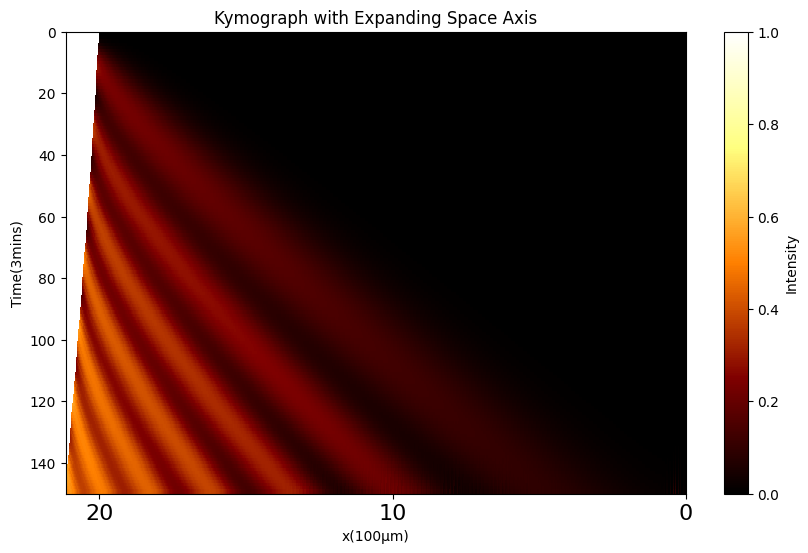

In [ ]:
### Plot kymograph

# Current time step
N = 150
# Initialize the figure and axis for the kymograph
fig, ax = plt.subplots(figsize=(10, 6))

# We will plot the kymograph as a collection of patches, one for each time step
for i in range(N):
    # Calculate the extent of the space axis for the current time step
    current_extent = L_values[2*i]
    # Calculate the x-axis values for the current time step
    x_values = np.linspace(0, current_extent, 501)
    # Select the appropriate row from the data array for the current time step
    row_data = kymo_E[i]
    # Define the y-axis range for the current time step
    y_values = [i,i+1]
    # Create a meshgrid for the x and y values
    X, Y = np.meshgrid(x_values, y_values)
    # Plot the data for the current time step as a patch
    quadmesh = ax.pcolormesh(X, Y, np.vstack([row_data, row_data]), shading='auto', cmap='afmhot',vmin=0,vmax=1)

# Set the labels and title of the kymograph
ax.set_xlabel('x(100μm)')
ax.set_ylabel('Time(3mins)')
ax.set_title('Kymograph with Expanding Space Axis')

# Adjust the limits of the y-axis to ensure all data is visible
ax.set_ylim(N, 0)
ax.set_xlim(current_extent, 0)
plt.xticks([20, 10,0], fontsize=16)

cbar = fig.colorbar(quadmesh, ax=ax)
cbar.set_label('Intensity')

# Show the plot
plt.show()

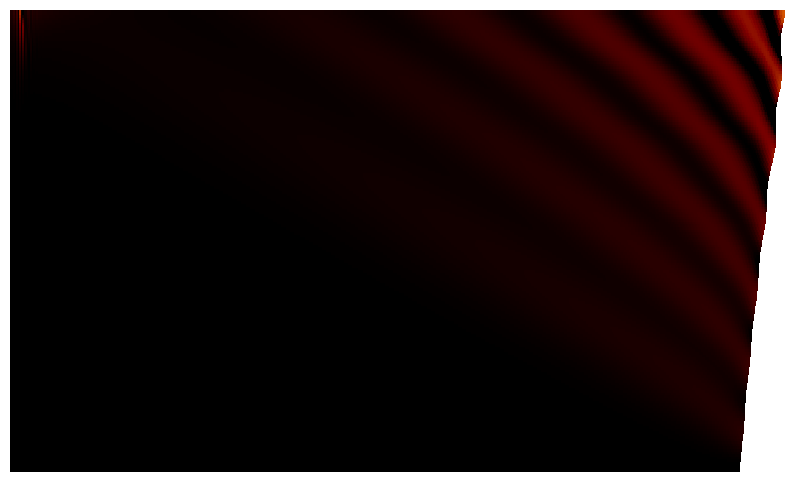

In [82]:
# Initialize the figure and axis for the kymograph
fig, ax = plt.subplots(figsize=(10, 6))
# Current time step
N = 180
# We will plot the kymograph as a collection of patches, one for each time step
for i in range(N):
    # Calculate the extent of the space axis for the current time step
    current_extent = L_values[2*i]
    # Calculate the x-axis values for the current time step
    x_values = np.linspace(0, current_extent, 501)
    # Select the appropriate row from the data array for the current time step
    row_data = kymo_E[i]
    # Define the y-axis range for the current time step
    y_values = [i, i+1]
    # Create a meshgrid for the x and y values
    X, Y = np.meshgrid(x_values, y_values)
    # Plot the data for the current time step as a patch
    quadmesh = ax.pcolormesh(X, Y, np.vstack([row_data, row_data]), shading='auto', cmap='afmhot', vmin=0, vmax=1)

# Remove all the axes, ticks, and labels
ax.axis('off')
plt.savefig("f4_4_1.svg", format="eps")  # 可以将"svg"替换为"pdf"或"eps"等格式
# Show the plot without any borders or labels
plt.show()